# Setup

## Imports

In [73]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(100)

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn import metrics

path = r"../../../data/raw/formula-1-world-championship-1950-2020/versions/24/"

## Reader Files

In [74]:
def create_dataframes_csv(path):
    frame = pd.read_csv(path)
    
    return frame

In [ ]:
def prefix_columns(df, table_name, exclude=None):
    if exclude is None:
        exclude = []
    return df.rename(columns={
        col: f"{table_name}__{col}" if col not in exclude else col
        for col in df.columns
    })

drivers = prefix_columns(create_dataframes_csv(f"{path}drivers.csv"), "drivers")
constructors = prefix_columns(create_dataframes_csv(f"{path}constructors.csv"), "constructors")
constructor_standings = prefix_columns(create_dataframes_csv(f"{path}constructor_standings.csv"), "constructor_standings")
qualifying = prefix_columns(create_dataframes_csv(f"{path}qualifying.csv"), "qualifying")
circuits = prefix_columns(create_dataframes_csv(f"{path}circuits.csv"), "circuits")
results = prefix_columns(create_dataframes_csv(f"{path}results.csv"), "results")
pit_stops = prefix_columns(create_dataframes_csv(f"{path}pit_stops.csv"), "pit_stops")
races = prefix_columns(create_dataframes_csv(f"{path}races.csv"), "races")

drivers = drivers.drop(columns=[
    "drivers__url", "drivers__dob"
])

constructors = constructors.drop(columns=[
    "constructors__url"
])

constructor_standings = constructor_standings.drop(columns=[
    "constructor_standings__positionText"
])

circuits = circuits.drop(columns=[
    "circuits__url", "circuits__alt", "circuits__lng", "circuits__lng"
])

results = results.drop(columns=[
    "results__positionText"
])

races = races.drop(columns=[
    "races__url"
])

total = pd.merge(drivers, results, left_on="drivers__driverId", right_on="results__driverId")
total = pd.merge(total, races, left_on="results__raceId", right_on="races__raceId")
total = pd.merge(total, circuits, left_on="races__circuitId", right_on="circuits__circuitId")
total = pd.merge(total, qualifying, left_on=["races__raceId", "drivers__driverId"], right_on=["qualifying__raceId", "qualifying__driverId"])
total = pd.merge(total, pit_stops, left_on=["qualifying__raceId", "qualifying__driverId"], right_on=["pit_stops__raceId", "pit_stops__driverId"])
total = pd.merge(total, constructors, left_on="qualifying__constructorId", right_on="constructors__constructorId")
total = pd.merge(total, constructor_standings, left_on="constructors__constructorId", right_on="constructor_standings__constructorId")

total = total.drop(columns=[
    "drivers__driverId",
    "results__driverId", "results__raceId", "results__constructorId", "results__statusId", "results__number", "results__driverId",
    "races__raceId", "races__circuitId",
    "circuits__circuitId",
    "qualifying__qualifyId", "qualifying__raceId", "qualifying__driverId", "qualifying__constructorId", "qualifying__number",
    "pit_stops__driverId",
    "constructors__constructorId",
    "constructor_standings__constructorStandingsId", "constructor_standings__raceId", "constructor_standings__constructorId"
])

total = total.drop_duplicates()

total


,drivers__driverRef,drivers__number,drivers__code,drivers__forename,drivers__surname,drivers__nationality,results__resultId,results__grid,results__position,results__positionOrder,...,pit_stops__lap,pit_stops__time,pit_stops__duration,pit_stops__milliseconds,constructors__constructorRef,constructors__name,constructors__nationality,constructor_standings__points,constructor_standings__position,constructor_standings__wins
0,hamilton,44,HAM,Lewis,Hamilton,British,20780,2,2,2,...,16,17:28:24,23.227,23227,mclaren,McLaren,British,14.0,1,1
1,hamilton,44,HAM,Lewis,Hamilton,British,20780,2,2,2,...,16,17:28:24,23.227,23227,mclaren,McLaren,British,24.0,1,1
2,hamilton,44,HAM,Lewis,Hamilton,British,20780,2,2,2,...,16,17:28:24,23.227,23227,mclaren,McLaren,British,28.0,3,1
3,hamilton,44,HAM,Lewis,Hamilton,British,20780,2,2,2,...,16,17:28:24,23.227,23227,mclaren,McLaren,British,34.0,3,1
4,hamilton,44,HAM,Lewis,Hamilton,British,20780,2,2,2,...,16,17:28:24,23.227,23227,mclaren,McLaren,British,42.0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5020547,doohan,61,DOO,Jack,Doohan,Australian,26759,17,15,15,...,22,17:37:42,22.080,22080,alpine,Alpine F1 Team,French,14.0,9,0
5020548,doohan,61,DOO,Jack,Doohan,Australian,26759,17,15,15,...,22,17:37:42,22.080,22080,alpine,Alpine F1 Team,French,49.0,6,0
5020549,doohan,61,DOO,Jack,Doohan,Australian,26759,17,15,15,...,22,17:37:42,22.080,22080,alpine,Alpine F1 Team,French,49.0,7,0
5020550,doohan,61,DOO,Jack,Doohan,Australian,26759,17,15,15,...,22,17:37:42,22.080,22080,alpine,Alpine F1 Team,French,59.0,6,0


In [76]:
print(total.columns)

Index(['drivers__driverRef', 'drivers__number', 'drivers__code',
       'drivers__forename', 'drivers__surname', 'drivers__nationality',
       'results__resultId', 'results__grid', 'results__position',
       'results__positionOrder', 'results__points', 'results__laps',
       'results__time', 'results__milliseconds', 'results__fastestLap',
       'results__rank', 'results__fastestLapTime', 'results__fastestLapSpeed',
       'races__year', 'races__round', 'races__name', 'races__date',
       'races__time', 'races__fp1_date', 'races__fp1_time', 'races__fp2_date',
       'races__fp2_time', 'races__fp3_date', 'races__fp3_time',
       'races__quali_date', 'races__quali_time', 'races__sprint_date',
       'races__sprint_time', 'circuits__circuitRef', 'circuits__name',
       'circuits__location', 'circuits__country', 'circuits__lat',
       'qualifying__position', 'qualifying__q1', 'qualifying__q2',
       'qualifying__q3', 'pit_stops__raceId', 'pit_stops__stop',
       'pit_stops__lap', 

# Fastest lap prediction

### Dataset

In [87]:
def time_to_seconds(t):
    try:
        if t == "0:00.000" or pd.isna(t):
            return 0.0
        mins, rest = t.split(":")
        return int(mins) * 60 + float(rest)
    except:
        return 0.0

circuit = input(str("Circuit: "))

fastes_lap_data = pd.DataFrame()

fastes_lap_data = total[["drivers__code", "drivers__number", "drivers__nationality", 
                         "circuits__name",
                         "qualifying__q1", "qualifying__q2", "qualifying__q3",
                         "results__fastestLapTime",
                         "races__date"]]

fastes_lap_data = fastes_lap_data.drop_duplicates()

for index, row in fastes_lap_data.iterrows():
    if (str(row["circuits__name"]).lower() != circuit.lower()):
        fastes_lap_data.drop(index, inplace=True)

fastes_lap_data[["qualifying__q1", "qualifying__q2", "qualifying__q3"]] = \
    fastes_lap_data[["qualifying__q1", "qualifying__q2", "qualifying__q3"]].fillna("0:00.000")

for col in ["qualifying__q1", "qualifying__q2", "qualifying__q3"]:
    fastes_lap_data[col] = fastes_lap_data[col].apply(time_to_seconds)

meta = fastes_lap_data[["races__date", "drivers__code", "drivers__number", "circuits__name"]].reset_index(drop=True)

X_full = pd.concat([fastes_lap_data[["qualifying__q1", "qualifying__q2", "qualifying__q3"]],
                    pd.get_dummies(fastes_lap_data[["drivers__code", "drivers__number", 
                                                    "drivers__nationality", "circuits__name"]], drop_first=True)],
                   axis=1)

fastes_lap_data["fastestLapSeconds"] = fastes_lap_data["results__fastestLapTime"].apply(time_to_seconds)
y_full = fastes_lap_data["fastestLapSeconds"]


In [88]:
fastes_lap_data

,drivers__code,drivers__number,drivers__nationality,circuits__name,qualifying__q1,qualifying__q2,qualifying__q3,results__fastestLapTime,races__date,fastestLapSeconds
32515,HAM,44,British,Circuit de Spa-Francorchamps,123.008,122.823,108.730,1:55.647,2011-08-28,115.647
94008,HAM,44,British,Circuit de Spa-Francorchamps,120.368,109.067,121.012,1:51.596,2013-08-25,111.596
105598,HAM,44,British,Circuit de Spa-Francorchamps,127.280,126.609,125.819,1:53.707,2014-08-24,113.707
118103,HAM,44,British,Circuit de Spa-Francorchamps,108.908,108.024,107.197,1:52.504,2015-08-23,112.504
130608,HAM,44,British,Circuit de Spa-Francorchamps,110.033,0.000,0.000,1:51.583,2016-08-28,111.583
...,...,...,...,...,...,...,...,...,...,...
4832255,ZHO,24,Chinese,Circuit de Spa-Francorchamps,106.178,106.085,0.000,1:52.317,2022-08-28,112.317
4841586,ZHO,24,Chinese,Circuit de Spa-Francorchamps,120.832,0.000,0.000,1:50.188,2023-07-30,110.188
4930257,PIA,81,Australian,Circuit de Spa-Francorchamps,114.835,114.136,114.027,1:45.840,2024-07-28,105.840
4966690,SAR,2,American,Circuit de Spa-Francorchamps,121.535,0.000,0.000,1:50.486,2023-07-30,110.486


## Trainen

In [89]:
X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(
    X_full, y_full, meta, test_size=0.5, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))


MAE: 1.6285620661157059


In [90]:
results_df = pd.DataFrame({
    "Date": meta_test["races__date"].values,
    "Driver": meta_test["drivers__code"].values,
    "Number": meta_test["drivers__number"].values,
    "Circuit": meta_test["circuits__name"].values,
    "Predicted (s)": y_pred,
    "Actual (s)": y_test.values
})

results_df["Date"] = pd.to_datetime(results_df["Date"])
results_df = results_df.sort_values(by=["Date", "Actual (s)"])

results_df


,Date,Driver,Number,Circuit,Predicted (s),Actual (s)
66,2011-08-28,BAR,\N,Circuit de Spa-Francorchamps,112.64274,110.424
113,2011-08-28,SEN,\N,Circuit de Spa-Francorchamps,111.85482,113.585
14,2011-08-28,KOB,10,Circuit de Spa-Francorchamps,111.71477,113.871
32,2011-08-28,KOV,\N,Circuit de Spa-Francorchamps,112.94443,114.051
22,2011-08-28,PER,11,Circuit de Spa-Francorchamps,112.00235,114.244
...,...,...,...,...,...,...
108,2024-07-28,TSU,22,Circuit de Spa-Francorchamps,112.18488,107.969
63,2024-07-28,ALB,23,Circuit de Spa-Francorchamps,107.02141,107.996
0,2024-07-28,ALO,14,Circuit de Spa-Francorchamps,106.66785,108.051
11,2024-07-28,STR,18,Circuit de Spa-Francorchamps,107.09173,108.105


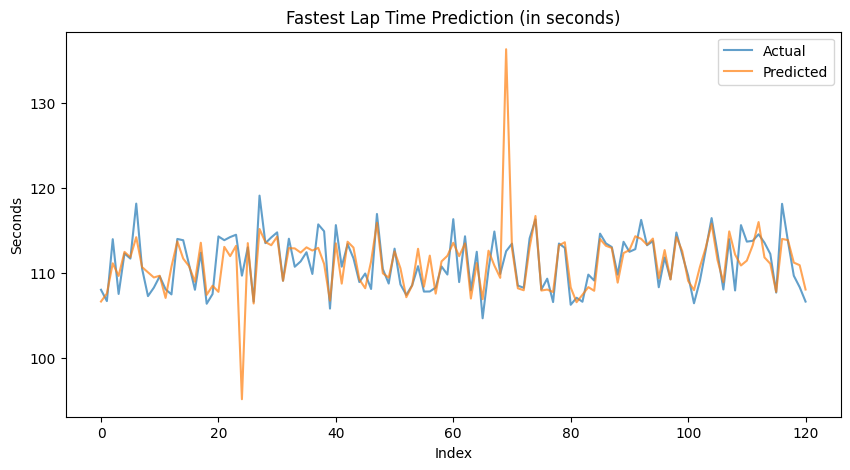

In [91]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Actual", alpha=0.7)
plt.plot(y_pred, label="Predicted", alpha=0.7)
plt.title("Fastest Lap Time Prediction (in seconds)")
plt.ylabel("Seconds")
plt.xlabel("Index")
plt.legend()
plt.show()


## Decision Tree

Regressor wordt gebruikt i.p.v. Class, omdat er gewerkt wordt met float nummers, inplaats van normale nummers

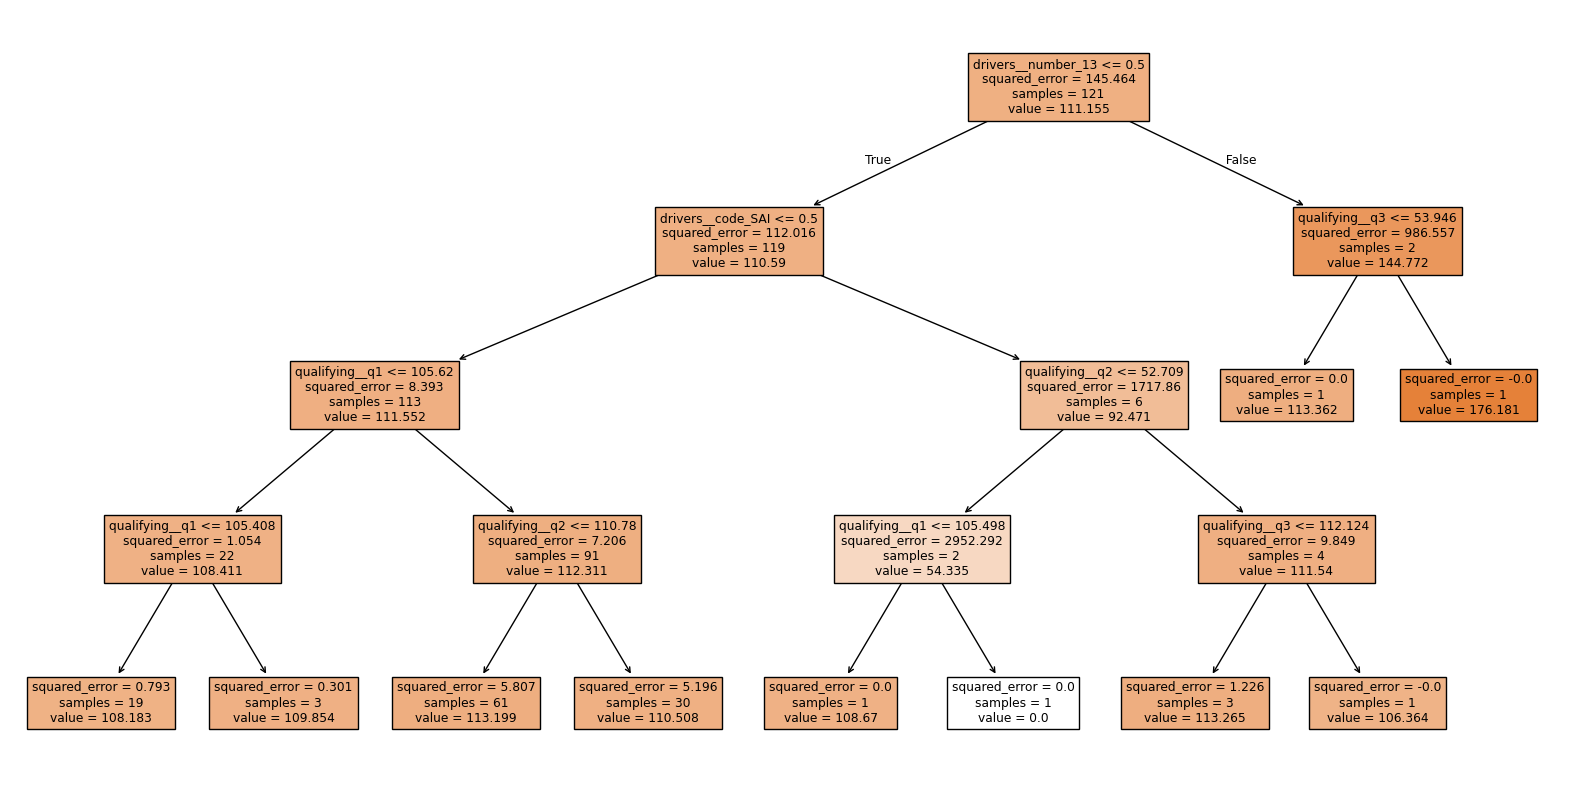

In [92]:
dtree = DecisionTreeRegressor(max_depth=4, random_state=42)
dtree.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
tree.plot_tree(dtree, feature_names=X_train.columns, filled=True)
plt.show()


## Confusion Matrix

In [93]:
def predict(X_test, y_test, predict_column_name, y_column_name):
    predicted_df = pd.DataFrame(dtree.predict(X_test), columns=[predict_column_name])
    actual_df = y_test.reset_index(drop=True).to_frame(name=y_column_name)
    return pd.concat([actual_df, predicted_df], axis=1)


In [94]:
model_results_frame = predict(X_test, y_test, "Predicted (s)", "Actual (s)")
model_results_frame

,Actual (s),Predicted (s)
0,108.051,110.507500
1,106.721,108.183474
2,113.995,110.507500
3,107.560,113.198590
4,112.317,113.198590
...,...,...
116,118.150,113.198590
117,113.760,113.198590
118,109.700,113.198590
119,108.357,113.198590


In [95]:
actual = []
predicted = []

for x in model_results_frame["Actual (s)"]:
    actual.append(int(x))
    
for x in model_results_frame["Predicted (s)"]:
    predicted.append(int(x))
    
print(len(actual), len(predicted))

121 121


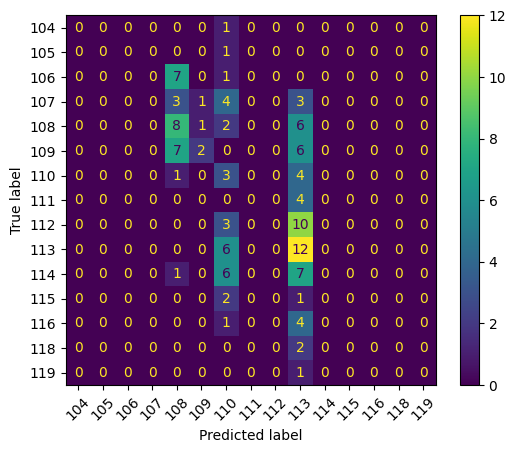

In [96]:
labels = sorted(set(actual) | set(predicted))

confusion_matrix = metrics.confusion_matrix(
    actual,
    predicted
)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
cm_display.plot()
plt.xticks(rotation=45)
plt.show()
